### This does not work well.  Note that in high dimensions, two random vectors are likely to be orthogonal.  This can be said of random vectors and the largest eigenvectors of the inverse Hessian.

In [2]:
import autograd
import autograd.numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import time

from copy import deepcopy
import scipy as sp
from scipy.sparse.linalg import LinearOperator
from scipy import optimize
from scipy import stats

In [427]:
class Objective(object):
    def __init__(self, k):
        self.k = k
        self.a = np.diag(np.full(k, 1.0)) + np.full((k, k), 0.1)
        #self.a = np.diag(np.linspace(2, 10, k) ** 2)
        self.grad = autograd.grad(self.objective)
        self.hessian = autograd.hessian(self.objective)
        self.hessian_vector_product = autograd.hessian_vector_product(self.objective)
        
    def objective(self, x):
        return 0.5 * np.matmul(x, np.matmul(self.a, x))

k = 100
obj = Objective(k)
x = np.random.random(obj.k)
obj.objective(x)
g = obj.grad(x)
hess = obj.hessian(x)
obj.hessian_vector_product(x, g)
xopt = np.full(obj.k, 0.)


In [429]:
def get_projection_matrix(mat):
    # Approximate the inverse Hessian with the projection onto the sketching vectors.
    mat_inner = np.matmul(mat.T, mat)
    proj_term = np.linalg.solve(mat_inner, mat.T)
    return np.matmul(mat, proj_term)

def make_orthogonal(mat, vec):
    proj_mat = get_projection_matrix(mat)
    vec = vec - np.matmul(proj_mat, vec)
    vec = vec / np.linalg.norm(vec)
    return vec

sketch_size = 5
#sketch_vecs = np.random.random((obj.k, sketch_size))
sketch_vecs_original = np.random.normal(size=(obj.k, sketch_size))
sketch_vecs = np.full_like(sketch_vecs_original, float('nan'))

# Orthogonalize the sketch.
sketch_vecs[:, 0] = sketch_vecs_original[:, 0]
sketch_vecs[:, 0] = sketch_vecs[:, 0] / np.linalg.norm(sketch_vecs[:, 0])
for ind in range(1, sketch_size):
    vec = make_orthogonal(sketch_vecs_original[:, range(ind)], sketch_vecs_original[:, ind])
    sketch_vecs[:, ind] = vec
    #proj_mat = get_projection_matrix(sketch_vecs_original[:, range(ind)])
    #sketch_vecs[:, ind] = np.matmul((id_mat - proj_mat), sketch_vecs_original[:, ind])
    #sketch_vecs[:, ind] = sketch_vecs[:, ind] / np.linalg.norm(sketch_vecs[:, ind])

print(np.matmul(sketch_vecs.T, sketch_vecs))

[[  1.00000000e+00  -1.08785593e-17  -1.46836815e-19   3.04678139e-18
    3.78221733e-18]
 [ -1.08785593e-17   1.00000000e+00  -4.96138920e-17   5.76458312e-17
    1.23593925e-17]
 [ -1.46836815e-19  -4.96138920e-17   1.00000000e+00   7.29517593e-17
    7.23101189e-17]
 [  3.04678139e-18   5.76458312e-17   7.29517593e-17   1.00000000e+00
   -3.16249623e-18]
 [  3.78221733e-18   1.23593925e-17   7.23101189e-17  -3.16249623e-18
    1.00000000e+00]]


In [403]:
hess_inv_products = np.full_like(sketch_vecs, float('nan'))

KLHessVecProdLO = LinearOperator((obj.k, obj.k), lambda vec: obj.hessian_vector_product(xopt, vec))

for ind in range(sketch_size):
    cg_res, info = sp.sparse.linalg.cg(KLHessVecProdLO, sketch_vecs[:, ind])
    hess_inv_products[:, ind] = cg_res

hess_inv = np.linalg.inv(obj.hessian(xopt))

# Approximate the inverse Hessian with the projection onto the sketching vectors.
sketch_inner = np.matmul(sketch_vecs.T, sketch_vecs)
sketch_proj_term = np.linalg.solve(sketch_inner, sketch_vecs.T)
sketch_proj = np.matmul(sketch_vecs, sketch_proj_term)
hess_inv_approx = np.matmul(hess_inv_products, sketch_proj_term)


/usr/local/lib/python3.5/dist-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


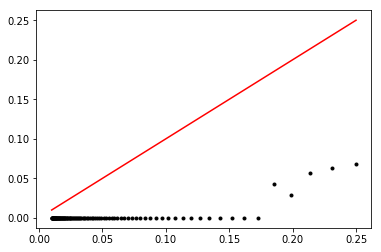

In [405]:
def plot_comparison(exact, approx):
    plt.plot(exact, approx, 'k.')
    line = [ np.min(exact), np.max(exact) ]
    plt.plot(line, line, 'r')

eigvals_approx = np.linalg.eigvals(hess_inv_approx)
eigvals_exact = np.linalg.eigvals(hess_inv)
plot_comparison(eigvals_exact, eigvals_approx)


Norm:  1.0
Projection error:  0.975484656077
Multiplication error:  0.0722276339507


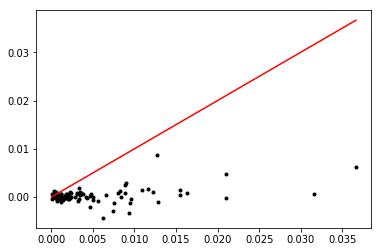

In [414]:
trial_vec = np.random.random(obj.k)
trial_vec = trial_vec / np.linalg.norm(trial_vec)

print('Norm: ',
      np.linalg.norm(trial_vec))
print('Projection error: ',
      np.linalg.norm(np.matmul(sketch_proj, trial_vec) - trial_vec))
hvp_approx = np.matmul(hess_inv_approx, trial_vec)
hvp_exact = np.linalg.solve(hess, trial_vec)
print('Multiplication error: ', np.linalg.norm(hvp_approx - hvp_exact))

plot_comparison(hvp_exact, hvp_approx)
